In [35]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from itertools import product
from difflib import SequenceMatcher

import re
import json
from pathlib import Path

import pandas as pd
import numpy as np

In [36]:
data_dir = Path("../data/tpch/")

In [37]:
data_dict = {}
json_paths = data_dir.glob("*.json")
for path in json_paths:
    with open(path, "r") as f:
        metric = path.name[:-24]
        results = json.load(f)["results"]
        metric_set = set()
        for src_data in results:
            for data in src_data["data"]:
                metric_set.add(data["metric"])
        for src_data in results:
            if src_data["source"][:10] != "summarizer":
                for data in src_data["data"]:
                    # jsonのキーは順番保証されていないので念の為ソート
                    tags = [data["tags"][key] for key in sorted(data["tags"].keys()) if key != "origin"]
                    key_name = metric
                    # metricフィールドが全て同じならキー名に含めない
                    if len(metric_set) > 1:
                        # metricフィールドの冗長な名前を簡潔化
                        metric_attr = re.findall('^.*\.(.*)$', data['metric'])[0]
                        key_name += f"-{metric_attr}"
                    if len(tags) > 0:
                        key_name += f"-{'-'.join(tags)}"
                    data_dict[key_name] = data["NumericType"]
df = pd.DataFrame(data_dict, dtype="float32")
df.dropna(inplace=True)
cpu_usage = df.filter(like="cpu-usage_user").sum(axis=1)
rm_indices = set(cpu_usage[cpu_usage < 15].index.to_list())
rm_indices = rm_indices | {idx + 1 for idx in rm_indices if idx < len(df)} | {idx - 1 for idx in rm_indices if idx > 1} | {idx - 2 for idx in rm_indices if idx > 2} |{1, len(df)}
df.drop(rm_indices, axis=0, inplace=True)

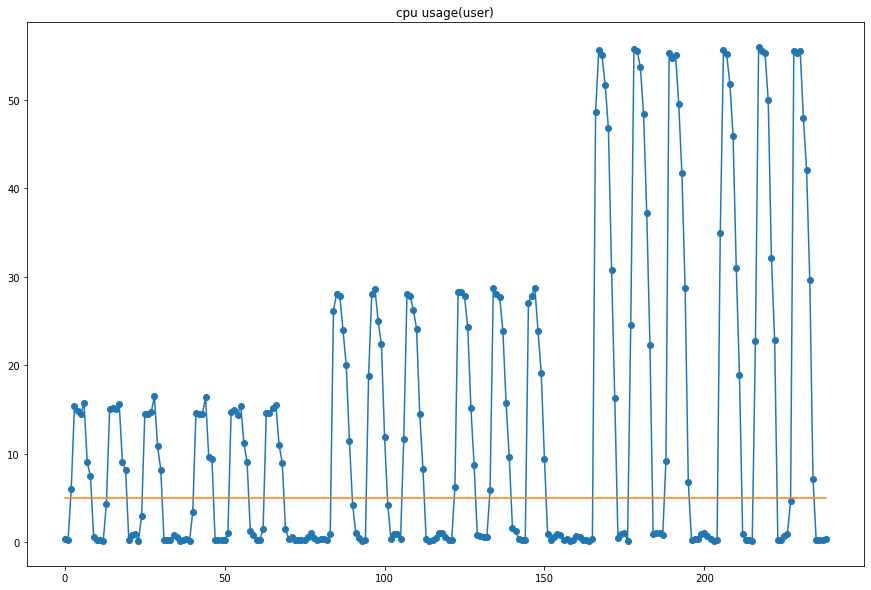

In [32]:
metric = "cpu usage(user)"
plt.figure(figsize=(15, 10))
plt.plot(range(len(cpu_usage)), cpu_usage, 'o-')
plt.plot(range(len(cpu_usage)), [5] * len(cpu_usage))
plt.title(metric)
plt.show()

In [34]:
# plt.figure(figsize=(10, 6))
# for metric in df.columns:
#     plt.plot(range(len(df)), df[metric])
#     plt.title(metric)
#     plt.show()

In [38]:
apj_metric_set = {'avg_cpu-usage_idle', 'avg_cpu-usage_softirq', 'avg_cpu-usage_system',
       'avg_cpu-usage_iowait', 'avg_cpu-usage_user', 'avg_cpu-usage_steal',
       'avg_cpu-usage_nice', 'avg_disk_busy-vdb', 'avg_disk_busy-vda2',
       'avg_disk_iops-writes-vda2', 'avg_disk_iops-writes-vdb',
       'avg_disk_iops-reads-vda2', 'avg_disk_iops-reads-vdb',
       'avg_handler-read_key', 'avg_handler-update', 'avg_handler-read_first',
       'avg_handler-rollback', 'avg_handler-write',
       'avg_handler-read_rnd_next', 'avg_handler-read_last',
       'avg_handler-read_next', 'avg_handler-external_lock',
       'avg_handler-read_rnd', 'avg_handler-commit', 'avg_handler-delete',
       'avg_handler-read_prev', 'avg_handler-prepare',
       'avg_innodb_rows_read-read', 'avg_innodb_rows_updated-inserted',
       'avg_innodb_rows_updated-deleted', 'avg_innodb_rows_updated-updated',
       'avg_memory_usage', 'avg_network_send_received-bytes_sent-eth0',
       'avg_network_send_received-bytes_recv-eth0', 'avg_pages_swap_in_out-in',
       'avg_pages_swap_in_out-out', 'avg_query_commands-select',
       'avg_query_commands-delete', 'avg_query_commands-update',
       'avg_query_commands-insert', 'avg_query_commands-replace',
       'avg_slow_query',
       'avg_threads_connected-mysql_global_status_threads_connected',
       'avg_threads_connected-mysql_global_status_threads_running',
       'disk_usage_(data_volume)___binlog_file_total_size-used-vdb',
       'disk_usage_(percent)-vdb', 'disk_usage_(percent)-vda2'}

In [42]:
tpch2apj = {key: None for key in df.keys()}
similarity_dict = {key: 0 for key in df.keys()}
for pair in product(df.keys(), apj_metric_set):
    tpch, apj = pair
    avg_tpch = "avg_" + tpch if tpch[:3] != "avg" else tpch
    avg_tpch = avg_tpch.replace("%", "percent")
    m1 = SequenceMatcher(None, avg_tpch, apj).ratio()
    m2 = SequenceMatcher(None, apj, avg_tpch).ratio()
    similarity = max(m1, m2)
    if similarity > similarity_dict[tpch]:
        tpch2apj[tpch] = apj
        similarity_dict[tpch] = similarity
# for key in tpch2apj.keys():
    # if similarity_dict[key] != 1.0:
        # print(key, '/', tpch2apj[key], '/', similarity_dict[key])

In [43]:
# tpchに存在するが，apjには存在しないメトリック

drop_pseudo_cols = [
    'cpu-usage_guest_nice',
    'cpu-usage_irq',
    'cpu-usage_guest',
    'handler-mrr_init',
    'handler-discover',
    'handler-savepoint',
    'handler-savepoint_rollback',
    'innodb_buffer_pool',
    'innodb_io_capacity',
    'query-commit',
    'query-drop_index',
    'query-alter_table',
    'query-drop_table',
    'query-create_table',
    'tmp_tables',
    'avg_lock_wait_time',
    'avg_sort-merge_passes',
    'buffer_hit_ratio%',
    'disk_used_(gb)-used',
    'disk_used_(gb)-total',
    'innodb_io-mysql_global_status_innodb_data_read',
    'innodb_io-mysql_global_status_innodb_data_written'
]

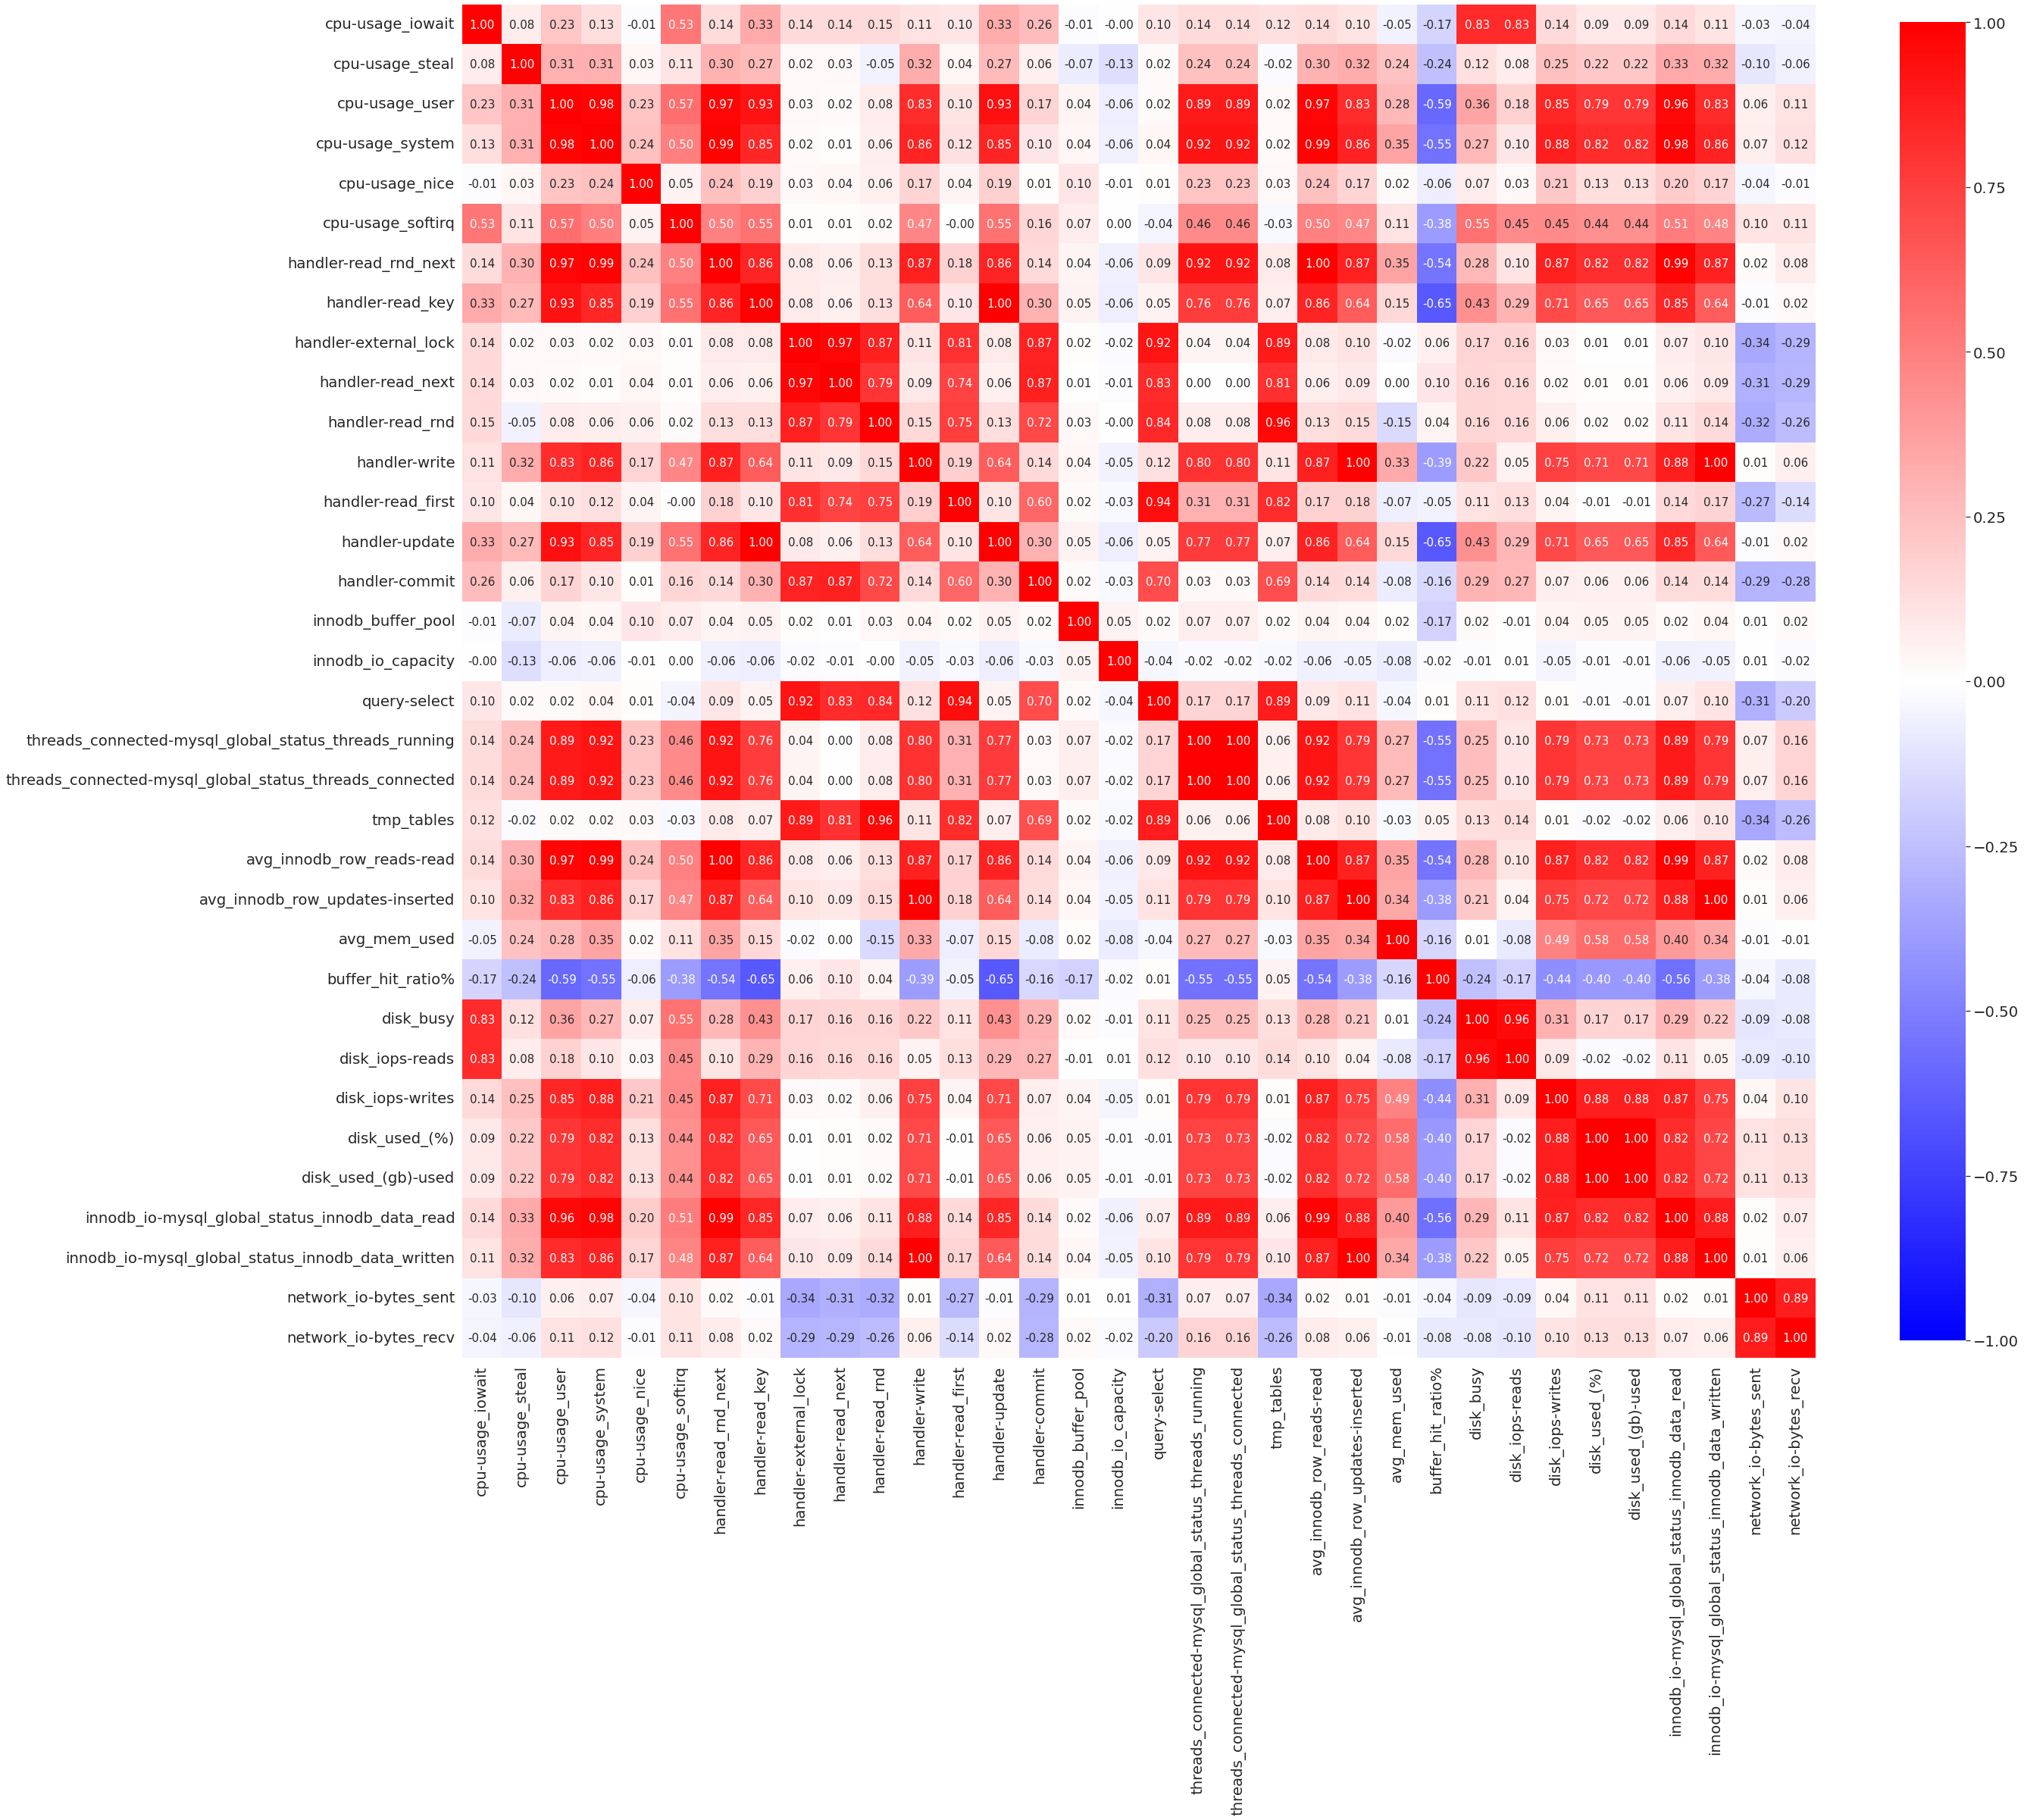

In [21]:
# 値が一定のメトリックを除いて分析
df_tmp = df.loc[:, df.nunique() != 1]

sns.set(font_scale=1.8)
plt.figure(figsize=(40, 40))
sns.heatmap(df_tmp.corr(), vmax=1, vmin=-1, center=0, annot=True, square=True, cmap="bwr", annot_kws={"size": 15}, cbar_kws={"shrink": 0.8}, fmt=".2f")
plt.show()

### 閾値を徐々に下げて削除していく
これにより相関が非常に高いものを優先的に削除できる

['cpu-usage_user',
 'cpu-usage_system',
 'handler-read_rnd_next',
 'handler-write',
 'handler-read_key',
 'handler-external_lock',
 'handler-read_rnd',
 'threads_connected-mysql_global_status_threads_running',
 'avg_innodb_row_reads-read',
 'avg_innodb_row_updates-inserted',
 'disk_busy',
 'disk_used_(%)',
 'handler-read_first',
 'innodb_io-mysql_global_status_innodb_data_read',
 'handler-read_next',
 'query-select',
 'disk_iops-writes',
 'network_io-bytes_sent',
 'cpu-usage_iowait',
 'threads_connected-mysql_global_status_threads_connected',
 'disk_used_(gb)-used']

the number of deleted metrics: 21


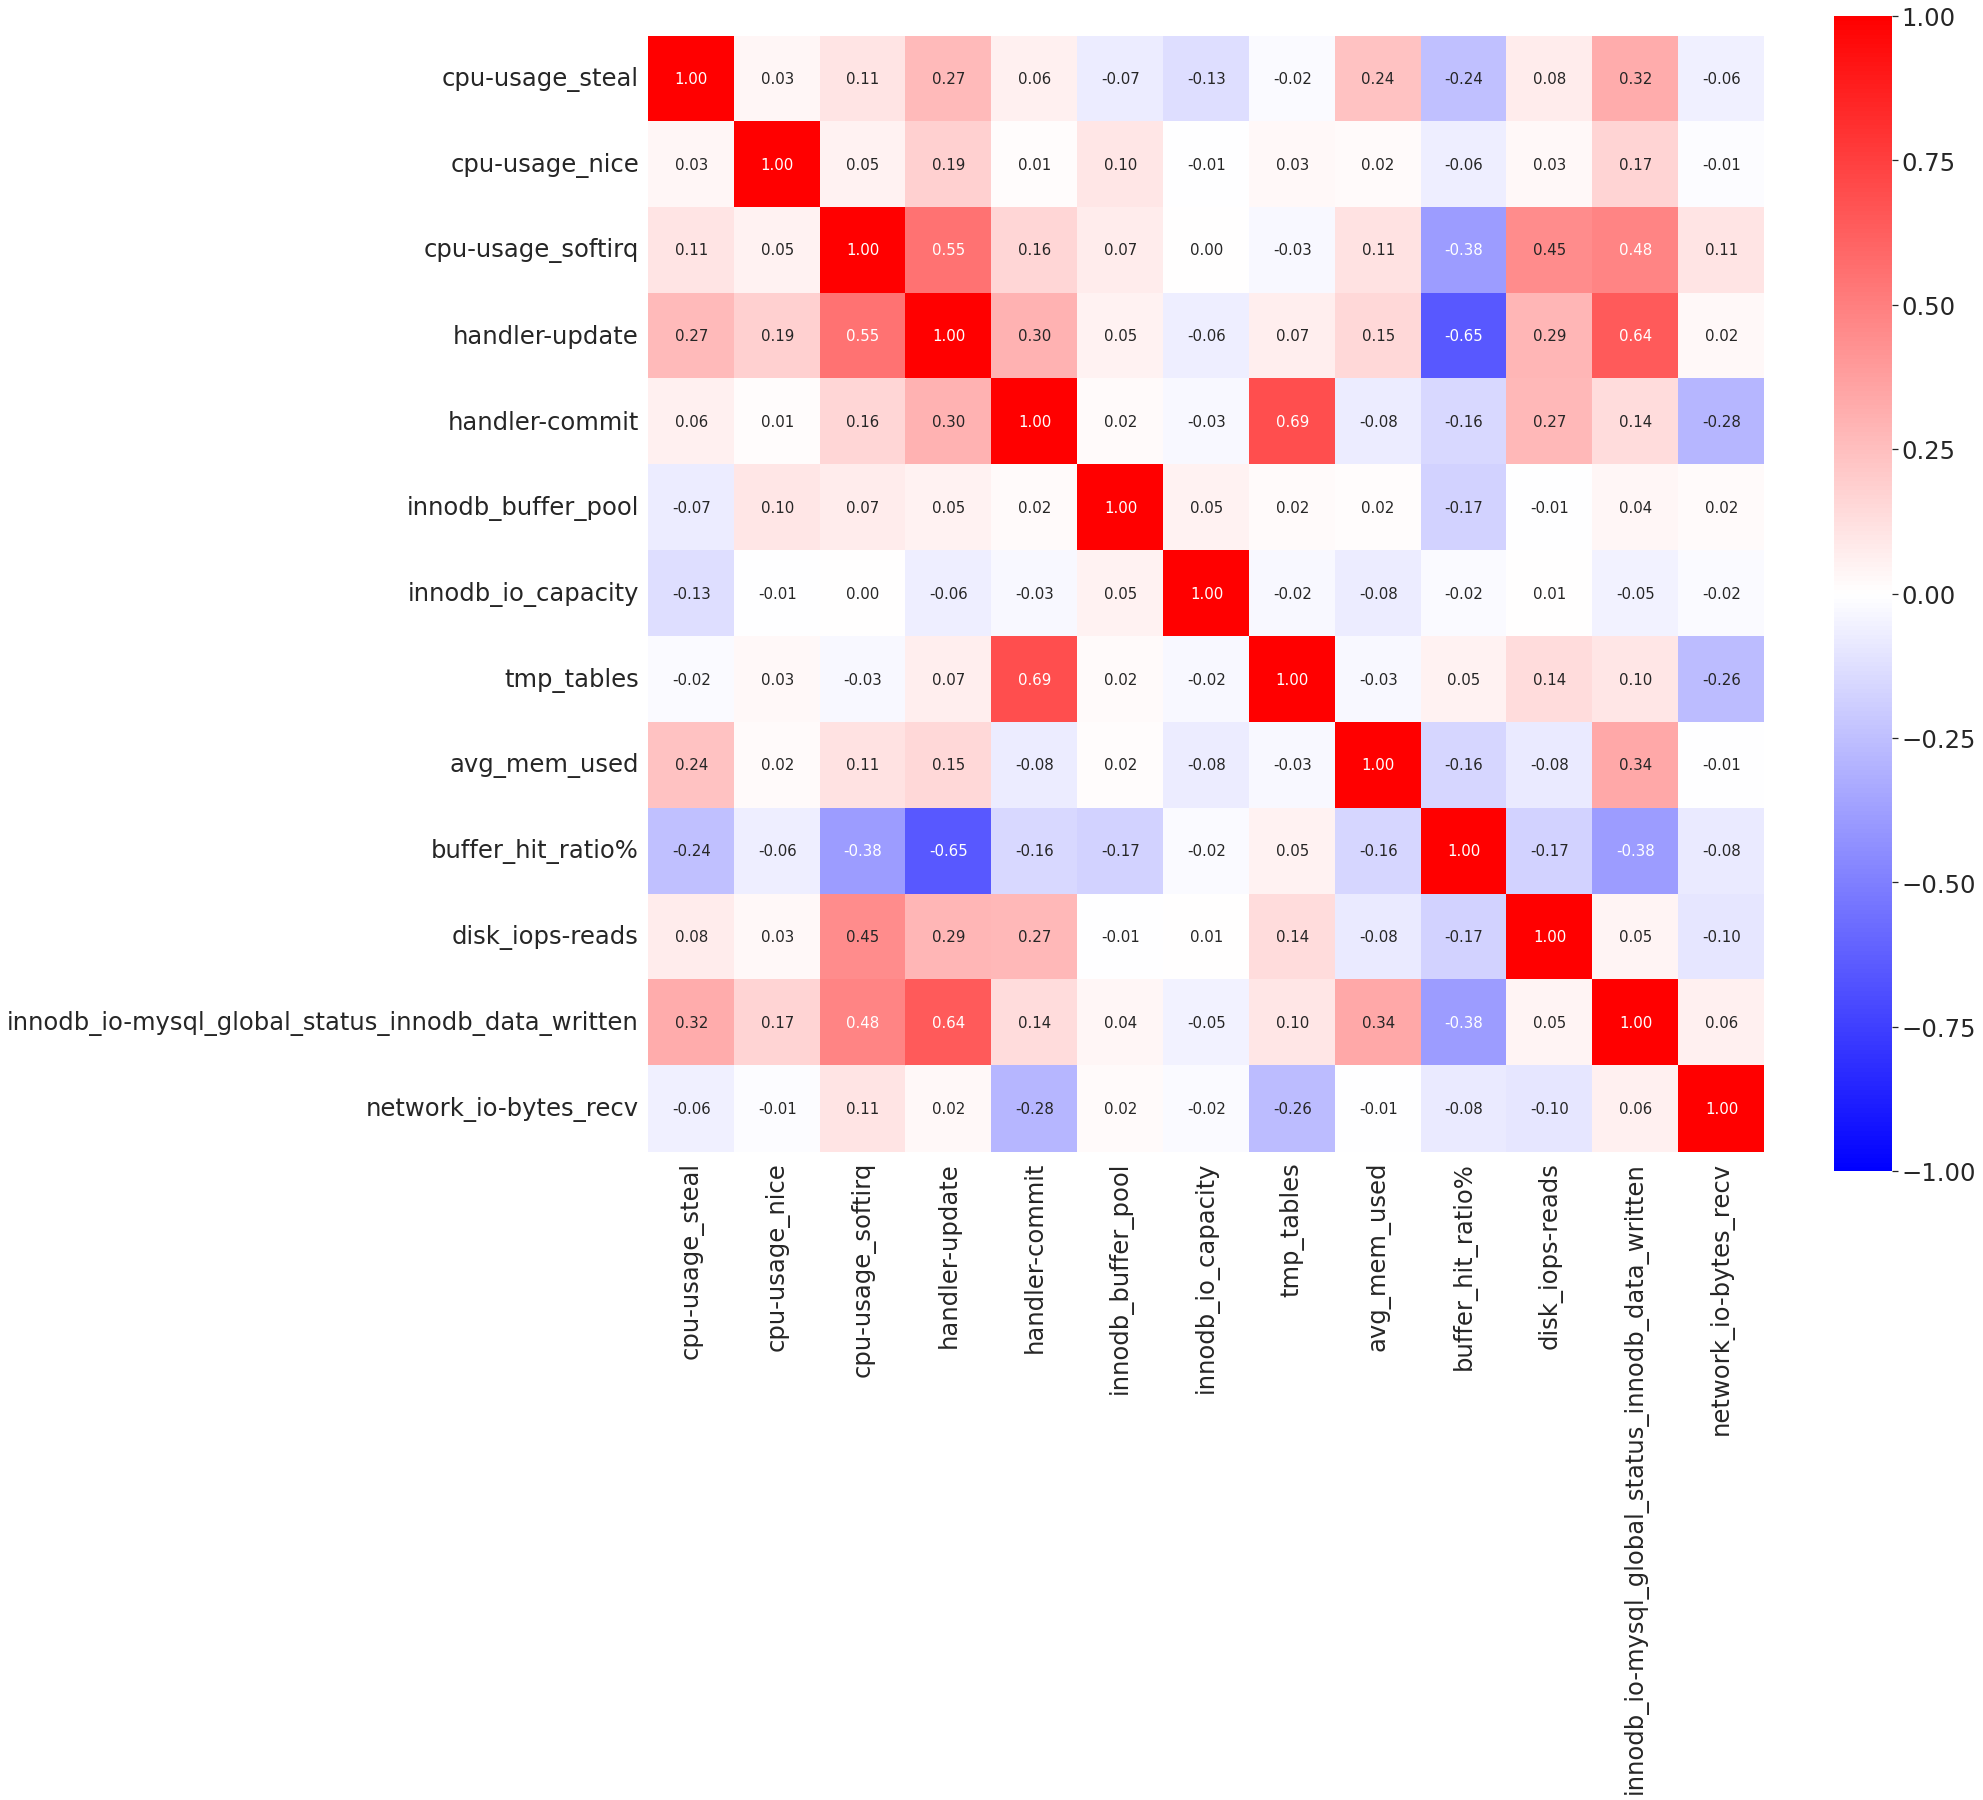

In [28]:
sns.set(font_scale=2.2)
df_tmp = df.loc[:, df.nunique() != 1]
df_selected = df_tmp.copy()
del_lim = 25
del_num = 0
ths = [0.95, 0.9, 0.85, 0.8, 0.75, 0.7]
del_metrics_all = []

for th in ths:
    df_corr = df_selected.corr()
    corr_mat = df_corr.to_numpy()
    cols = df_corr.columns

    # 相関が th 以上 or -th 以下のメトリックを取り出す
    high_corrs_dict = {k: set() for k in cols}
    for i, j in zip(*np.where((corr_mat >= th) | (corr_mat <= -th))):
        if i < j:
            # queryはworkloadを最もよく表しているので，消さないようにする
            if cols[i][:9] != "avg_query":
                high_corrs_dict[cols[i]].add(cols[j])
            if cols[j][:9] != "avg_query":
                high_corrs_dict[cols[j]].add(cols[i])
    del_metrics = []
    while del_num < del_lim:
        # 相関が高いメトリック間の関係数をメトリック別に列挙
        # （メトリックごとの関係数を相関係数の和で代用してもいい）
        del_metric = max(high_corrs_dict.items(), key=lambda item: len(item[1]))[0]
        if len(high_corrs_dict[del_metric]) == 0:
            break
        # keyを削除
        high_corrs_dict.pop(del_metric, None)
        # value(=set)の要素を削除
        for k, v_set in high_corrs_dict.items():
            if del_metric in v_set:
                v_set.discard(del_metric)
        del_metrics.append(del_metric)
        del_num += 1
    del_metrics_all += del_metrics
    df_selected.drop(del_metrics, axis=1, inplace=True)
pprint(del_metrics_all)
print(f"\nthe number of deleted metrics: {del_num}")
plt.figure(figsize=(25, 25))
sns.heatmap(df_selected.corr(), vmax=1, vmin=-1, center=0, annot=True, square=True, cmap="bwr", annot_kws={"size": 15}, fmt=".2f", cbar_kws={"shrink": 0.85})
plt.show()